<a href="https://colab.research.google.com/github/the-redback/deep-learning-getting-started/blob/master/08_Transfer_Learning_with_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning: MobileNet for the Cats vs Dogs dataset

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  !pip install -q -U "tensorflow-gpu==2.0.0rc0" 

try:
  %load_ext tensorboard
except:
  pass

TensorFlow 2.x selected.


In [0]:
!pip install -q -U tensorflow_hub
!pip install -q -U tensorflow_datasets

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load the Cats vs. Dogs Dataset

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(70, 20, 10))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [0]:
def format_image(image, label):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

## Transfer Learning with TensorFlow Hub

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

### Attach a classification head

In [0]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

In [0]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
510/510 [==============================] - 62s 121ms/step - loss: 0.0537 - accuracy: 0.9828 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
510/510 [==============================] - 48s 95ms/step - loss: 0.0304 - accuracy: 0.9898 - val_loss: 0.0341 - val_accuracy: 0.9890
Epoch 3/6
510/510 [==============================] - 48s 94ms/step - loss: 0.0248 - accuracy: 0.9924 - val_loss: 0.0396 - val_accuracy: 0.9858
Epoch 4/6
510/510 [==============================] - 48s 94ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 0.0332 - val_accuracy: 0.9884
Epoch 5/6
510/510 [==============================] - 48s 94ms/step - loss: 0.0178 - accuracy: 0.9940 - val_loss: 0.0347 - val_accuracy: 0.9875
Epoch 6/6
510/510 [==============================] - 48s 94ms/step - loss: 0.0159 - accuracy: 0.9947 - val_loss: 0.0390 - val_accuracy: 0.9860


### Visualize the accuracy

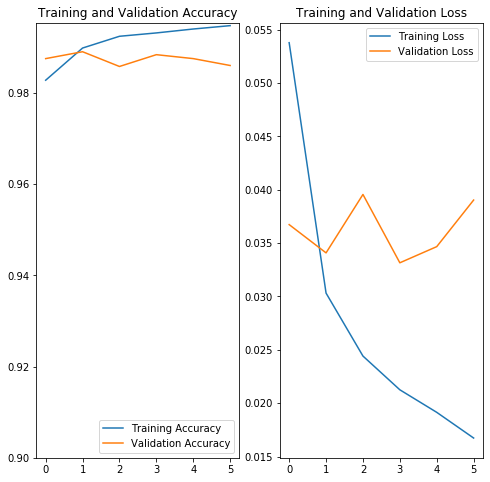

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim(ymin=.9)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Check the predictions

In [0]:
test_loss, test_accuracy = model.evaluate(test_batches)
print('Accuracy on test dataset:', test_accuracy)

73/73 [==============================] - 6s 83ms/step - loss: 0.0357 - accuracy: 0.9884
Accuracy on test dataset: 0.9883621


## Visualize the Prediction

In [0]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [0]:
image_batch, label_batch = next(iter(test_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat',
       'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog',
       'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat',
       'cat', 'cat', 'cat', 'dog', 'cat'], dtype='<U3')

In [0]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0]
Predicted labels:  [1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0]


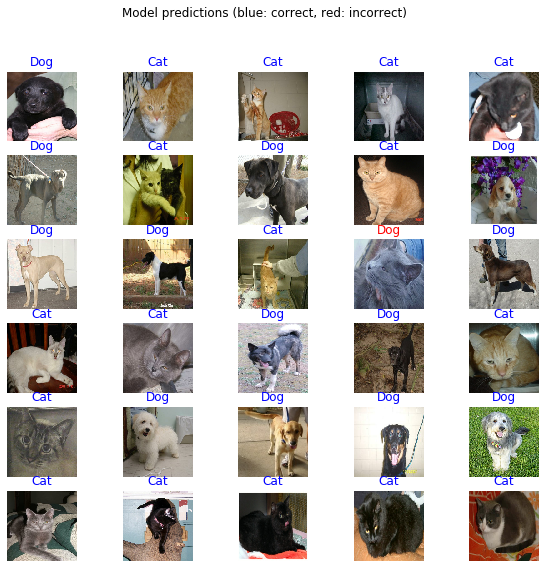

In [0]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")